# Image Classification with Convolutional Neural Networks

This chapter is about a very successful technique for image processing with neuronal networks: **convolution**. We are going to walk through
- how convolution works
- why convolutional neural networks are so promising for image processing
- what layers a convolutional neural network is built from and how they work

## Preamble

In [1]:
from tensorflow import keras
import numpy
import matplotlib.pyplot as plt
import seaborn

In [2]:
import ai_dojo
ai_dojo.setup_plot_style(dark=True)

In [3]:
from IPython.display import HTML

## What is Convolution?




Before we go into the mathematical definition of convolution, and how it can be done with neural networks, we start with an example from image processing. 



Let's load an example image:

In [4]:
from PIL import Image

In [5]:
img = Image.open("graphics/cat.jpg")

In [6]:
w,h = img.size

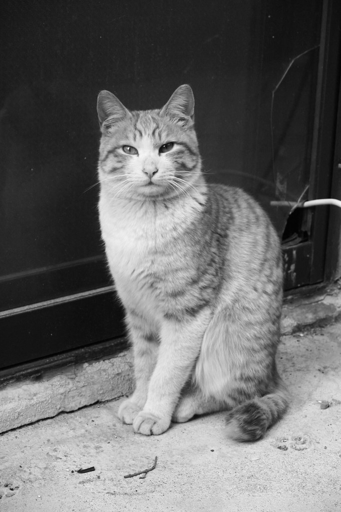

In [7]:
img = img.resize((w // 2, h // 2))
img = img.convert("L")
img

This cat picture is nothing but another tensor/array, containing grayscale pixel values.

In [8]:
img_a = numpy.array(img)
img_a.shape

(512, 341)

/var/folders/pl/9s2ysv_92pn6_2w7j2t40mh00000gn/T/ipykernel_89535/1009710385.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(img_a.flatten())


<AxesSubplot: ylabel='Density'>

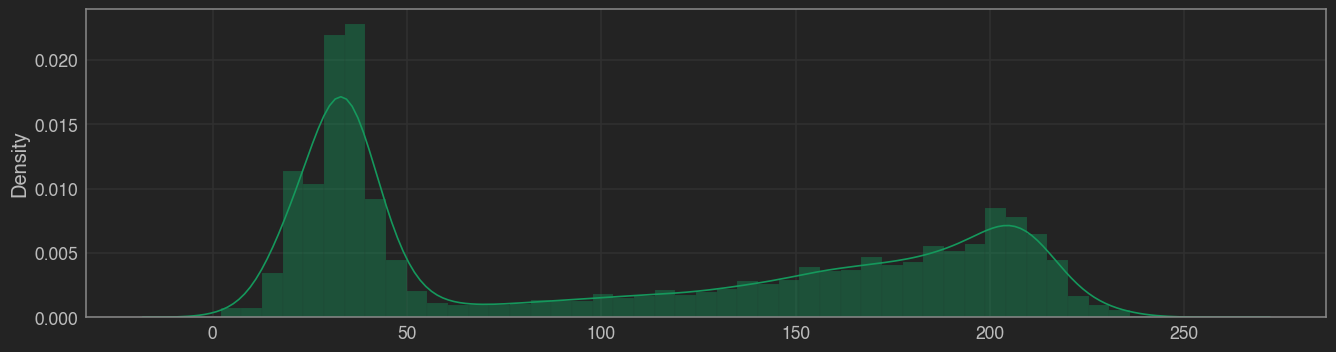

In [9]:
seaborn.distplot(img_a.flatten())

The second ingredient for the convolution is called **kernel**, **filter**, or **convolution matrix**.

In [10]:
kernel = numpy.array(
    [
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1]
    ]
)

This particular kind of kernel is well-known and has a name - the [**Sobel operator**](https://en.m.wikipedia.org/wiki/Sobel_operator). We will see what it does in a minute.

During the convolution, the kernel is shifted over the pixels of the the image to transform it into a new image. The entries in the matrix define how a new pixel value results from the values of neighboring pixels. Mathematically, the new pixel results from _matrix multiplication_ of the kernel with the part of the image that it covers at each step.

The `scipy` library has a function to perform this operation:

In [11]:
from scipy.signal import convolve2d


In [12]:
img_a_conv = convolve2d(img_a, kernel)

/var/folders/pl/9s2ysv_92pn6_2w7j2t40mh00000gn/T/ipykernel_89535/2335952764.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  seaborn.distplot(img_a_conv.flatten())


<AxesSubplot: ylabel='Density'>

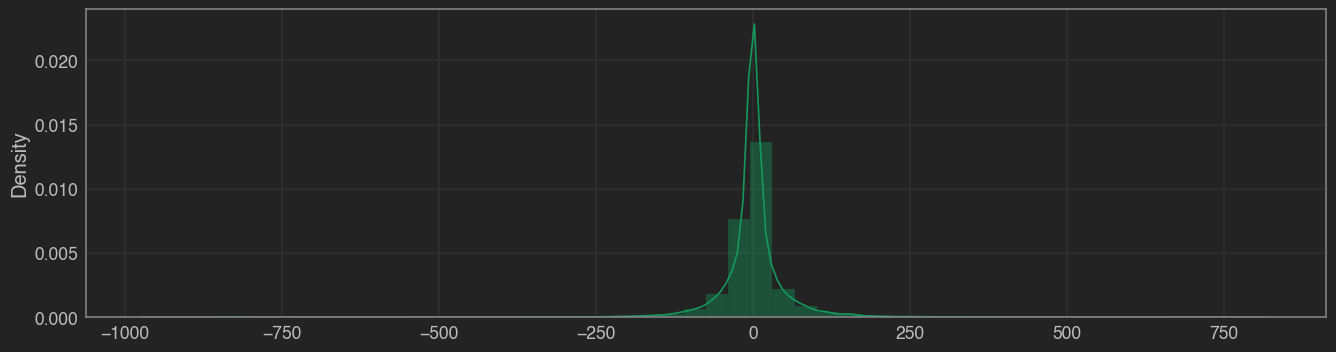

In [13]:
seaborn.distplot(img_a_conv.flatten())

Let's have a look at the new image after convolution:

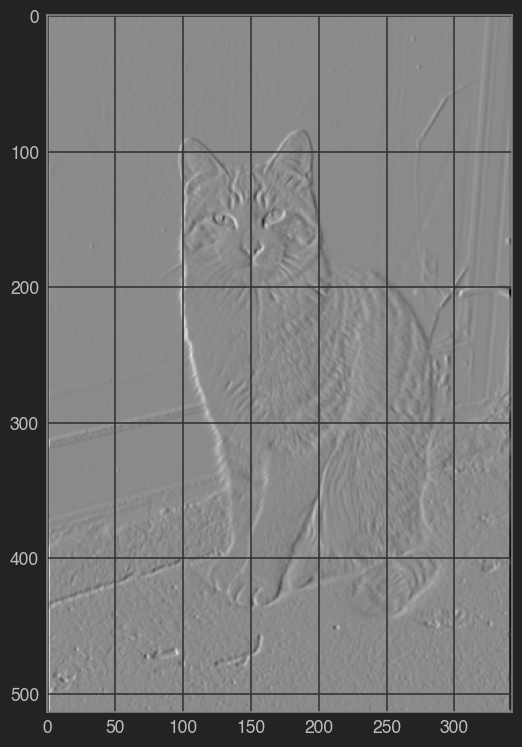

In [14]:
plt.figure(figsize=(w // 100, h // 100))
plt.imshow(img_a_conv, cmap="gray")

This kernel is a _vertical edge detector_. As you may guess, the transposed kernel...

In [15]:
kernel.transpose()

array([[ 1,  2,  1],
       [ 0,  0,  0],
       [-1, -2, -1]])

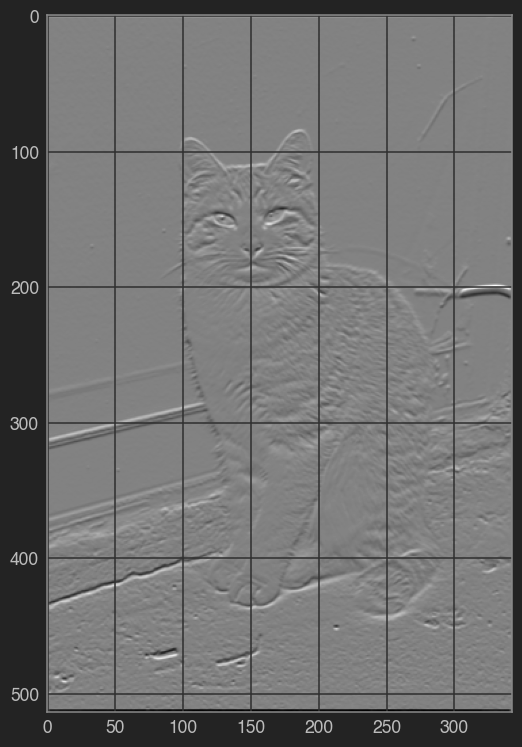

In [16]:
plt.figure(figsize=(w // 100, h // 100))
plt.imshow(
    convolve2d(img_a, kernel.transpose()),
    cmap="gray"
)

... does horizontal edge detection.

## Convolutional Neural Networks...

Now that we have an idea of how convolution works, we combine it with machine learning. The essential trick: **The filters - that is, the entries of the convolution matrix moved over the image - are no longer predefined, but can be learned by a neural network during the training process.** 

A convolutional neural network architecture can take advantage of the **hierarchical patterns** in an image by extracting them layer by layer: To say it in a simplified way, the first convolution detects edges, the next one detects shapes, and so on, until an object can be detected and classified.

To dig deeper into what a CNN sees, it is actually possible to visualize the activations on each layer. Here is an example where the first layers are apparently edge detectors. The deeper we go, the more abstract patterns emerge.

![](graphics/cnn_feature_viz.jpg)

[_Source_](https://www.researchgate.net/publication/319622441_DeepFeat_A_Bottom_Up_and_Top_Down_Saliency_Model_Based_on_Deep_Features_of_Convolutional_Neural_Nets/figures?lo=1)

##  ... and their Building Blocks

Like other neural networks, convolutional architectures are composed of layers. We introduce two new layer types:

**`Convolution2D`**: This layer performs convolution over the two-dimensional input tensor (for example, the input image). As in the example above, a kernel is shifted over the image, but this time, the entries in the convolution matrix are learnable parameters.

![](graphics/conv_layer_anim.gif)

In order to extract features from the image, it makes sense to perform multiple convolutions with different kernels over the same input (think vertical plus horizontal edge detection..). 

This brings us to the two most important parameters of this layer:

- `filters`: the number of convolutions performed over the input
- `kernel_size`: the shape of the convolution matrix

**`MaxPooling2D`**: This layer reduces the size of the input by looking at a certain window and selecting only the maximum value. This way, **the max-pooling operator performs de-noising as well as dimensionality reduction.**

![](graphics/pooling_layer_anim.gif)

It has one main parameter:

- `pool_size`: the shape of the pooling window


In general, a convolutional layer is  followed by a pooling layer in a CNN. It is typical to stack several of these convolution/pooling pairs to make the network deeper.

## Interactive Demos

### The CNN Explainer

The [CNN Explainer](https://github.com/poloclub/cnn-explainer) is a great open-source demo of a convolutional architecture for image classification.

In [17]:
HTML('<iframe src=https://poloclub.github.io/cnn-explainer/ width=100% height=800></iframe>')

/Users/cls/miniforge3/envs/ai-training/lib/python3.9/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


## Digit Classification with a Convolutional Neural Network

We are now going to revisit the digit classification problem, but this time we try a convolutional architecture.

In [18]:
(X_train, y_train),(X_test, y_test) = keras.datasets.mnist.load_data()

In [19]:
X_train.shape

(60000, 28, 28)

In [20]:
X_train, X_test = X_train / 255.0, X_test / 255.0

In [21]:
img_size = 28

In [22]:
X_train = X_train.reshape(-1, img_size, img_size, 1)
X_test = X_test.reshape(-1, img_size, img_size, 1)
input_shape = (img_size, img_size, 1)
n_classes = 10

In [23]:
X_train = numpy.expand_dims(X_train, 3)

### Network Architecture

In the following we are going to train a network with the following convolutional architecture: Two sets of convolution/max pooling layers are followed by a flattening operator, a fully-connected layer and an output layer with ten neurons for digit classification.

![](graphics/convnet_architecture.jpg)

_[Source](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)_ 

In [24]:
n1 = 4    # number of filters in first convolutional layer
n2 = 8   # number of filters in second convolutoinal layer
n3 = 16   # number of neurons in final dense layer

n_classes = 10

net = keras.models.Sequential(
    [
        keras.layers.Convolution2D(
            filters=n1,
            kernel_size=(3,3),
            activation="relu",
        ),
        keras.layers.MaxPooling2D(
            pool_size=(2,2)
        ),
        keras.layers.Convolution2D(
            filters=n2,
            kernel_size=(3,3),
            activation="relu"
        ),
        keras.layers.MaxPooling2D(
            pool_size=(2,2)
        ),
        keras.layers.Flatten(),
        keras.layers.Dense(
            units=n3,
            activation="relu"
        ),
        keras.layers.Dense(
            units=n_classes,
            activation="softmax"
        )
        
    ]
)

### Excercise: Train and Evaluate the CNN Network

In [25]:
# your code here

## References

- [A Comprehensive Guide to Convolutional Neural Networks — the ELI5 way](https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53)

---
_This notebook is licensed under a [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/). Copyright © 2018-2021 [Point 8 GmbH](https://point-8.de)_